# Import All Needed Libraries

In [6]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

%load_ext autoreload
%autoreload 2

from src.ATR import atr_wilder
from src.RSI import rsi_wilder
from src.VWAP import vwap
from src.MACD import macd
from src.SR import support_resistance
from src.backtest import plot_equity_curve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load Csv
df = pd.read_csv("/workspaces/BinaryTradingBots/data/btcusd_15-min_data.csv", parse_dates= ['timestamp'])

# Set timestamp as index
df.set_index("timestamp", inplace=True)


# Add Sma
sma_lengths = [50, 200]
for length in sma_lengths:
    sma = ta.sma(df["close"], length=length)
    df[f"sma{length}"] = sma

# Add Rsi
df["rsi"] = rsi_wilder(df["close"]).shift(1)

# Add atr
df["atr"] = atr_wilder(df).shift(1)

# Add Vwap
df["vwap"] = vwap(df).shift(1)

# Add MACD
df["macd"] = macd(df).shift(1)

#Add Support and Resistance 
df = support_resistance(df, lookback=200)

# Now shift to avoid leakage
df["resistance"] = df["resistance"].shift(1)
df["support"] = df["support"].shift(1)

# Add target
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# Drop empty rows
df.dropna(inplace=True)

print(df.tail())

                              open     high      low    close     volume  \
timestamp                                                                  
2026-02-15 22:45:00+00:00  68994.0  69037.0  68891.0  68917.0  23.809241   
2026-02-15 23:00:00+00:00  68954.0  68954.0  68292.0  68460.0  80.243542   
2026-02-15 23:15:00+00:00  68460.0  68628.0  68365.0  68615.0  21.635241   
2026-02-15 23:30:00+00:00  68617.0  68752.0  68517.0  68653.0  45.243957   
2026-02-15 23:45:00+00:00  68644.0  68792.0  68635.0  68792.0   7.486973   

                              sma50     sma200        rsi         atr  \
timestamp                                                               
2026-02-15 22:45:00+00:00  69076.56  69473.045  56.757986  225.212398   
2026-02-15 23:00:00+00:00  69037.70  69470.680  54.082214  219.554370   
2026-02-15 23:15:00+00:00  69002.04  69469.420  41.559412  251.157629   
2026-02-15 23:30:00+00:00  68967.48  69468.255  46.116651  252.003513   
2026-02-15 23:45:00+00:00  68

In [8]:
features = ["rsi", "volume", "atr", "macd", "vwap"]
x = df.drop(columns="target")
y = df["target"]

# Split
split_idx = int(len(x) * 0.8)

x_train = x[:split_idx]
x_test = x[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# Create model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train 
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5142470430188985


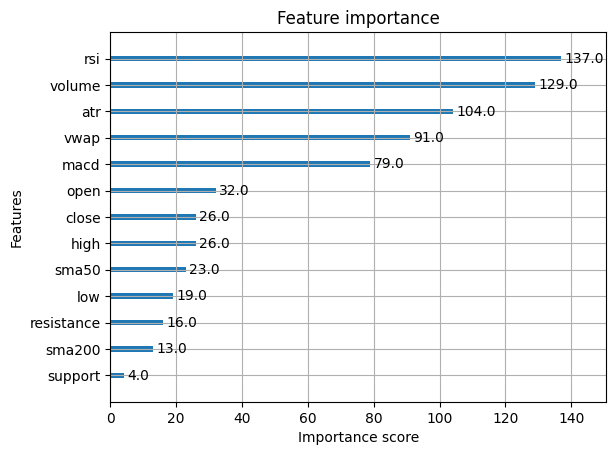

In [9]:
xgb.plot_importance(model)
plt.show()

In [10]:
# Correlation with target
correlations = df[features + ["target"]].corr()["target"].drop("target")
print(correlations.sort_values(ascending=False))

vwap      0.059193
atr       0.041318
volume    0.035285
macd     -0.007904
rsi      -0.031418
Name: target, dtype: float64
